In [1]:
from gurobipy import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('../data/evo_travels.csv')

In [ ]:
# limpeza

# only travels with more than 30 minutes of duration, that is the limit of cancellation of a reserve
data = evo_travels[(evo_travels['duration'] > 30) | (evo_travels['distance'] > 3)]

# Colleting vehicle ids
car_ids = list(evo_travels.Id.unique())

# Removing uncommon ids
# Ex: 4c5865a3-4b03-40f6-a3a8-d4e94aae3b17
ids_uncommon = [id for id in car_ids if id.find('-') != -1]
car_ids = [id for id in car_ids if id.find('-') == -1]

evo_travels = evo_travels[~evo_travels.Id.isin(ids_uncommon)]

In [3]:
data.head()

,Id,Start_time,Start_lat,Start_lon,Fuel_start,End_time,End_lat,End_lon,Fuel_end,duration,distance
0,JTDKDTB32G1589000,2018-03-01 12:42:24.630568,49.225563,-122.894234,84,2018-03-01 13:21:04.095771,49.314045,-123.083481,84,38.657753,1.688120e+04
1,JTDKDTB32G1589000,2018-03-01 18:09:30.383898,49.314045,-123.083481,84,2018-03-01 18:33:40.410390,49.314045,-123.083481,84,24.167108,0.000000e+00
2,JTDKDTB32G1589000,2018-03-01 18:36:09.073847,49.314045,-123.083481,84,2018-03-01 20:24:36.451198,49.315067,-123.083481,83,108.456289,1.136032e+02
3,JTDKDTB32G1589000,2018-03-01 20:39:21.714875,49.315067,-123.083481,83,2018-03-01 21:09:48.876096,49.315067,-123.083481,83,30.452687,7.068790e-10
4,JTDKDTB32G1589000,2018-03-01 21:12:05.647857,49.315067,-123.083481,83,2018-03-01 21:15:26.307443,49.315067,-123.083481,83,3.344326,7.068790e-10


### Localizando viagens por regiões em vez de coordenadas

In [4]:
# Creating points of Vancouver region
latitudes = []
longitudes = []
step =0.004
for lat in np.arange(data['Start_lat'].min(),data['Start_lat'].max()+step,step):
    for lon in np.arange(data['Start_lon'].min(),data['Start_lon'].max()+step,step):
        latitudes.append(lat)
        longitudes.append(lon)
        
points = pd.DataFrame({'lon':longitudes, 'lat':latitudes})

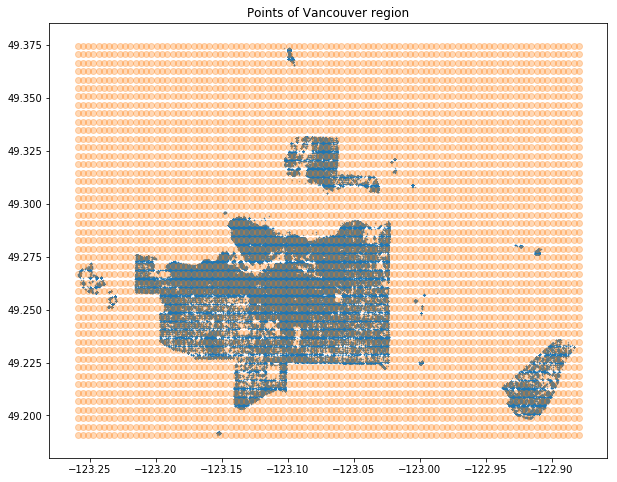

In [5]:
plt.figure(figsize=(10,8))
plt.scatter(data['Start_lon'], data['Start_lat'], s=0.1)
plt.scatter(points['lon'], points['lat'], alpha=0.3)
plt.title('Points of Vancouver region')

plt.show()

In [18]:
def geojson_builder(down_left,up_right,n_vehicles=0):
    """
    Build a rectangle geojson from two points.
    """
    p1 = [str(down_left[0]),str(down_left[1])]
    p2 = [str(up_right[0]),str(down_left[1])]
    p3 = [str(up_right[0]),str(up_right[1])]
    p4 = [str(down_left[0]),str(up_right[1])]
    
    geojson = {"type": "FeatureCollection",
              "features": [
                {"type": "Feature",
                    "properties":{
                        "travels": n_vehicles
                    },
                    "geometry": {
                        "type": "Polygon",
                        "coordinates": [[p1,p2,p3,p4,p1]] }}]}

    return geojson

In [19]:
def build_regions(data, points):
    """
    Create a list of geojsons that represent the group more 
    significant in the region.
    """
  
    # Creating matrix of the region coordinates
    # matrix dimensions based in points
    lat = points['lat'].unique()
    step = round(abs(lat[0]-lat[1]),5)
    diff = abs(lat.max() - lat.min())

    len_y = int(diff/step)+1

    lon = points['lon'].unique()
    step = round(abs(lon[0]-lon[1]),5)
    diff = abs(lon.max() - lon.min())

    len_x = int(diff/step)+1
    
    
    matrix = []

    # filling the matrix with the points coordinates
    c = 0
    for y in range(len_y):
        line = []
        for x in range(len_x):
            line.append((points['lon'].iloc[c], points['lat'].iloc[c]))
            c+=1
        matrix.append(line)

    geojsons = []
    
    # Column options for travels and idle datasets
    start_lat = 'Start_lat'
    start_lon = 'Start_lon'
    end_lat = 'End_lat'
    end_lon = 'End_lon'
    
    for lin in range(len(matrix)-1):
        for col in range(len(matrix[0])-1):

            # Selecting all points inside a square of matrix coordinates
            down_left = matrix[lin][col]
            up_right = matrix[lin+1][col+1]
            
            start_lon_condition = (data[start_lon] >= down_left[0]) & (data[start_lon] <= up_right[0])
            start_lat_condition = (data[start_lat] >= down_left[1]) & (data[start_lat] <= up_right[1])
            
            end_lon_condition = (data[end_lon] >= down_left[0]) & (data[end_lon] <= up_right[0])
            end_lat_condition = (data[end_lat] >= down_left[1]) & (data[end_lat] <= up_right[1])

            start_travels = data.loc[start_lon_condition & start_lat_condition]
            end_travels = data.loc[end_lon_condition & end_lat_condition]

#             if len(start_travels) != 0:
            # Build a geojson
            geojsons.append(geojson_builder(down_left,up_right))

            # Changing start region of the travels
            data.loc[start_lon_condition & start_lat_condition, 'start_region'] = len(geojsons)-1
            data.loc[end_lon_condition & end_lat_condition, 'end_region'] = len(geojsons)-1

            
    return geojsons

In [20]:
regions = build_regions(data, points)

In [26]:
len(regions)

4275

In [25]:
data.head()

,Id,Start_time,Start_lat,Start_lon,Fuel_start,End_time,End_lat,End_lon,Fuel_end,duration,distance,start_region,end_region
0,JTDKDTB32G1589000,2018-03-01 12:42:24.630568,49.225563,-122.894234,84,2018-03-01 13:21:04.095771,49.314045,-123.083481,84,38.657753,1.688120e+04,851.0,2893.0
1,JTDKDTB32G1589000,2018-03-01 18:09:30.383898,49.314045,-123.083481,84,2018-03-01 18:33:40.410390,49.314045,-123.083481,84,24.167108,0.000000e+00,2893.0,2893.0
2,JTDKDTB32G1589000,2018-03-01 18:36:09.073847,49.314045,-123.083481,84,2018-03-01 20:24:36.451198,49.315067,-123.083481,83,108.456289,1.136032e+02,2893.0,2988.0
3,JTDKDTB32G1589000,2018-03-01 20:39:21.714875,49.315067,-123.083481,83,2018-03-01 21:09:48.876096,49.315067,-123.083481,83,30.452687,7.068790e-10,2988.0,2988.0
4,JTDKDTB32G1589000,2018-03-01 21:12:05.647857,49.315067,-123.083481,83,2018-03-01 21:15:26.307443,49.315067,-123.083481,83,3.344326,7.068790e-10,2988.0,2988.0


In [23]:
# dados que serão utilizados no modelo
time_instants = pd.date_range(start=data.Start_time.min(), end=data.End_time.max(), freq='min')
time_instants = [t.value for t in time_instants] # Todos os instantes de tempo em timestamp
viagem_id = data.index                           # id de todas as viagens
n_vehicles = len(data.Id.unique())               # numero total de veículos

In [5]:
m = Model("realocacao")

Academic license - for non-commercial use only


In [31]:
# Variável que indica se ocorreu a viagem
# listando todas as opções oq não pode ser ideal
# essa representação ainda irá traduzir as realocações
locais = [None,1,2,3]
viagens_relizadas = dict()
for v in viagem_id:
    for l in locais:
        viagens_relizadas[(v,l)] = m.addVar(vtype=GRB.BINARY)

In [16]:
# Variável que indica quantos veículos estão em cada estação em dado momento
locais = [1,2,3]
veiculos_ocisos = dict()
for l in locais:
    for t in time_instants:
        veiculos_ocisos[(l,t)] = m.addVar(vtype=GRB.INTEGER)